In [42]:
#import the required libarries

import os #interact with the OS
import random
import skimage
from skimage import data, transform, io
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.layers import Flatten, Dense
from keras. optimizers import Adam
from keras.activations import relu
from keras.models import Sequential

#allows image embedding in the notebook
%matplotlib inline

In [43]:
import skimage.data
#parse and load the training data
def load_data(data_dir):
    """loads a data set and returns two lists:
    images -> a list of np arrayes , each reping an image
    labels -> a list of numbers that rep the image labels
    """

    #get the subdirs of data_dir . Eac should rep a label
    directories = [d for d in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, d))]

    #loop through the labels dirs and collect the data in the two lists
    labels = []
    images = []

    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                        for f in os.listdir(label_dir) if f.endswith(".ppm")]


         #for each label, load its images and add themto the image list.
         # later, add the label number - directory name to the label list

        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

#load the training and testing datasets
root_path = "/home/machio_b/Documents/Data_Sets/"
train_data_dir = os.path.join(root_path, "Training")
test_data_dir = os.path.join(root_path, "Testing")

images, labels = load_data(train_data_dir)

#exploring the datasets
print(" labels: {0}\n images: {1}".format(len(set(labels)), len(images)))

 labels: 62
 images: 4575


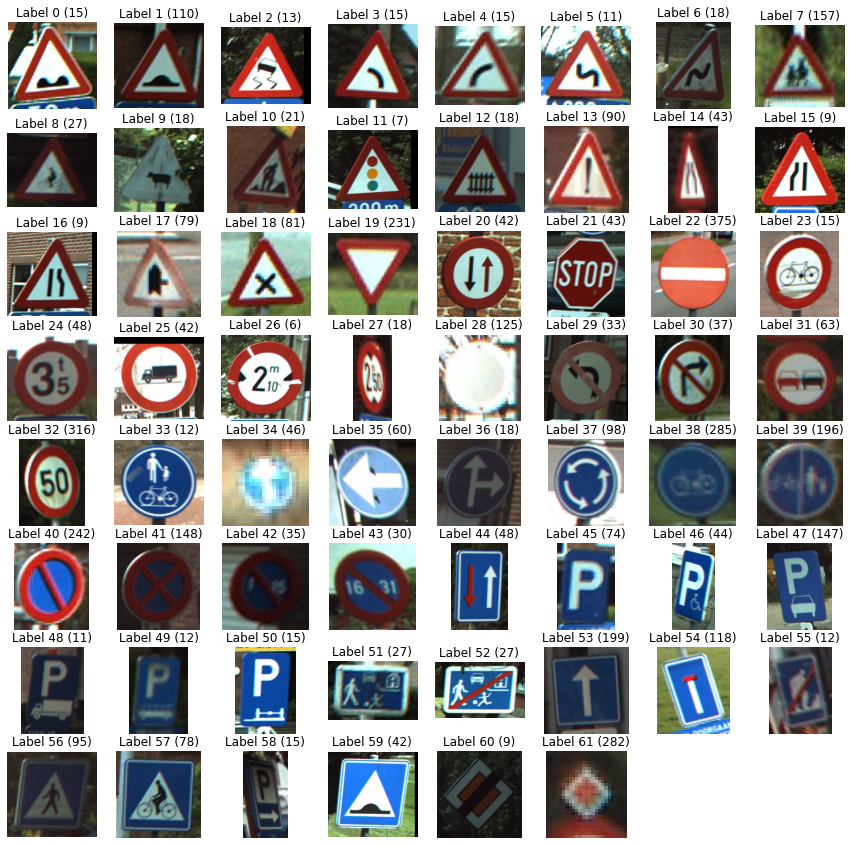

In [44]:
#Diplay the first image of each label

def display_images_and_labels(images,labels):
    """Display the first image of each label."""
    u_labels = set(labels)
    plt.figure(figsize=(15,15))
    i = 1

    for label in u_labels: #l for labels
        image = images[labels.index(label)]
        plt.subplot(8,8,i) #qa grid of 8 rows and 8 columns
        plt.axis('off')
        plt.title('Label {0} ({1})'.format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    #plt.show()

display_images_and_labels(images, labels)

In [45]:
# def display_label_images(images, label):
#     """Display images of a specific label."""
#     limit = 24  # show a max of 24 images
#     plt.figure(figsize=(15, 5))
#     i = 1

#     start = labels.index(label)
#     end = start + labels.count(label)
#     for image in images[start:end][:limit]:
#         plt.subplot(3, 8, i)  # 3 rows, 8 per row
#         plt.axis('off')
#         i += 1
#         plt.imshow(image)
#     plt.show()

# display_label_images(images, 15)

In [46]:
#Nets expect fixed image input size

#check the input size of our images

for image in images[:5]:
    print("shape: {0}, min: {1}, max:{2}".format(image.shape, image.min(), image.max()))

#128 x 128 -. resize to 32x32 for -> fast training and recognition 
# this normalizes the images -> 0 to 1

images32 = [skimage.transform.resize(image, (32,32), mode='constant')
            for image in images]
#display_images_and_labels(images32, labels)

for image in images32[:5]:
    print("shape: {0}, min: {1}, max:{2}".format(image.shape, image.min(), image.max()))

shape: (123, 123, 3), min: 7, max:255
shape: (110, 96, 3), min: 3, max:255
shape: (171, 176, 3), min: 0, max:255
shape: (88, 86, 3), min: 14, max:255
shape: (82, 82, 3), min: 9, max:238
shape: (32, 32, 3), min: 0.03518889369521859, max:0.9999998875202283
shape: (32, 32, 3), min: 0.07541052805726804, max:0.9999999999750386
shape: (32, 32, 3), min: 0.058783157009743466, max:0.9901950851643424
shape: (32, 32, 3), min: 0.0860566343489467, max:0.9999991827330359
shape: (32, 32, 3), min: 0.0544902037059032, max:0.9233315884599308


In [47]:
#by this we gwt to accurately know the minimum viable model
labels_a = np.array(labels)
images_a = np.array(images32)
print(" labels: ", labels_a.shape, "\nimages: ",images_a.shape)

 labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [48]:
#create a graph to hold the model
graph = tf.Graph()

#create a model in the graph
with graph.as_default():
    #tf.compat.v1.disable_v2_behavior()
    #placeholders for imputs and labels
    #images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    images_ph = tf.compat.v1.placeholder(tf.float32, shape=[None,32,32,3])
    labels_ph = tf.compat.v1.placeholder(tf.int32, shape=[None])

    #Flatten the input:  Convert the data into a 1-Dimensional array for input the next layer
    #from [None, Height, width and channel] to [None, height*width*channels] == [None, 3072]
    images_flat = tf.compat.v1.layers.flatten(images_ph)
    
    #Fully connected layer -> Dense
    #generate lgits of sizxe [None, 62]
    logits = tf.compat.v1.layers.dense(images_flat, 62, tf.nn.relu)
    

    #convert the logits inot label indexes (int)
    #Shape[None], this is a 1D vector of lenght == batch_size
    predicted_labels = tf.argmax(logits, 1)

    #define the loss function -> cross_entropy
    #loss = tf.compat.v1.losses.reduce_mean(tf.sparse_softmax_cross_entropy_with_logits(logit = logits, labels = labels_ph))
    loss = (tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))
    #create a training ops
    train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    #create a train operation
    #train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    #an initialization ops to execeute before 3training
    init = tf.compat.v1.global_variables_initializer()


print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("flatten/Reshape:0", shape=(None, 3072), dtype=float32)
logits:  Tensor("dense/Relu:0", shape=(None, 62), dtype=float32)
loss:  Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(None,), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(None,), dtype=int64)


/tmp/ipykernel_51264/1412480434.py:14: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  images_flat = tf.compat.v1.layers.flatten(images_ph)
/tmp/ipykernel_51264/1412480434.py:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(images_flat, 62, tf.nn.relu)


In [49]:
#create a session to run the graph that we created

session = tf.compat.v1.Session(graph=graph)

#first -> initialize all the variables
_ = session.run([init])


In [50]:
for i in range(201):
    _, loss_value = session.run([train, loss],
                                feed_dict={images_ph: images_a, labels_ph:labels_a})
    
    if i % 10 == 0:
        print("loss: ", loss_value)

loss:  [3.6225324 4.0730553 4.194284  ... 4.820652  4.8078527 4.9168873]
loss:  [1.900362  2.372322  2.3593328 ... 6.123975  5.890153  6.293704 ]
loss:  [0.77732545 1.0814532  1.13273    ... 5.972846   5.85289    6.4277625 ]
loss:  [0.4988569 0.7196137 0.5999579 ... 6.2494574 6.089436  6.66361  ]
loss:  [0.4543004  0.63455725 0.42165968 ... 6.218563   5.9923034  6.475957  ]
loss:  [0.40264016 0.53376466 0.33295363 ... 6.072774   5.7938237  6.1901608 ]
loss:  [0.35167155 0.44931787 0.2748017  ... 5.9321527  5.6380205  5.971809  ]
loss:  [0.32360777 0.4060891  0.23636156 ... 5.756607   5.4731693  5.775892  ]
loss:  [0.28998393 0.36174142 0.20574763 ... 5.6275845  5.353652   5.654308  ]
loss:  [0.2609145  0.3256805  0.18259177 ... 5.482243   5.2272296  5.5334473 ]
loss:  [0.22903684 0.28740472 0.1605931  ... 5.371895   5.137092   5.4509025 ]
loss:  [0.20355035 0.25750384 0.14206995 ... 5.2618294  5.0477376  5.3650675 ]
loss:  [0.18445723 0.23566054 0.12630972 ... 5.1869125  4.9808064  5.3

In [57]:
#pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

#run the predicted_labels op
predicted = session.run([predicted_labels],
                            feed_dict={images_ph: sample_images})[0]

print(sample_labels)
print(predicted)

[10, 31, 47, 40, 51, 38, 1, 57, 54, 22]
[ 1 32 47 40 56 38  1 56 54 22]


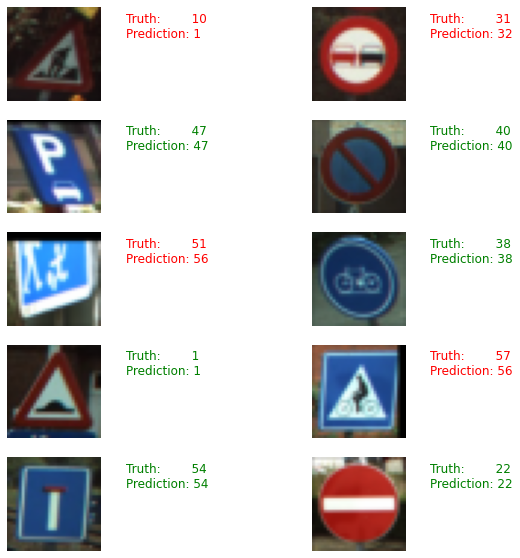

In [58]:
fig = plt.figure(figsize=(10,10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [59]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

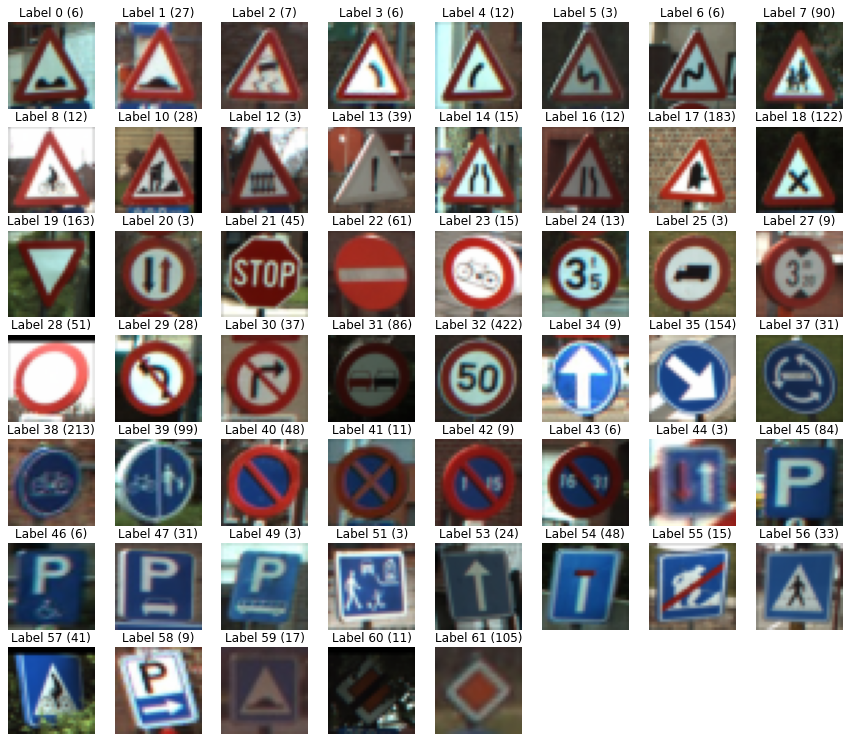

In [60]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [62]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.686
